In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"

# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)
from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

## Define Tool Node
from typing import Literal

from agents import(
    AgentState,
    agent_names,
    analyst_node,
    food_data_collector_node,
    realestate_data_collector_node,
    data_analyst_node,
    reporter_node,
)
from tools import get_tools_output, all_tools
from chat_history import save_chat_history, load_chat_history

tool_node = ToolNode(all_tools)


def analyst_router(state) -> Literal["call_tool", "__end__", "realestate_data_collector", "food_data_collector", "reporter", "analyst"]:
    # This is the router
    business_type = state.get("user_request", {}).get('business type', "")
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "real estate" in business_type:
        return "realestate_data_collector"    
    if "food" in business_type:
        return "food_data_collector"
    else:
        return "continue"


def router(state) -> Literal["call_tool", "__end__"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
workflow.add_node('analyst', analyst_node)
workflow.add_node('food_data_collector', food_data_collector_node)
workflow.add_node('realestate_data_collector', realestate_data_collector_node)
workflow.add_node('data_analyst', data_analyst_node)
workflow.add_node('reporter', reporter_node)
    
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "analyst",
    analyst_router,
    {
        "call_tool": "call_tool", 
        "__end__": END,
        "realestate_data_collector":"realestate_data_collector",
        "food_data_collector":"food_data_collector",
        "continue": "food_data_collector", 
        }
)

workflow.add_conditional_edges(
    "food_data_collector",
    router,
    {
        "call_tool": "call_tool", 
        "continue": "data_analyst", 
        }
)

workflow.add_conditional_edges(
    "realestate_data_collector",
    router,
    {
        "call_tool": "call_tool", 
        "continue": "data_analyst", 
        }
)

workflow.add_conditional_edges(
    "data_analyst",
    router,
    {
        "call_tool": "call_tool", 
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    analyst_router,
    {
        "__end__": END,
        "realestate_data_collector":"realestate_data_collector",
        "food_data_collector":"food_data_collector",
        "continue": "food_data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_names},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()

def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=20
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    # memory only keep chat history only along agents.
    internal_level_memory = MemorySaver()
    graph = workflow.compile(checkpointer=internal_level_memory)

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit, "thread_id":"a"},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER:", "")
    response = response.replace("FINALANSWER,", "")
    response = response.replace("FINALANSWER", "")
    
    restrict_str_size = lambda response: response[200:] + "..."
    
    if keep_chat_history:
        save_chat_history(bot_message=restrict_str_size(response), human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

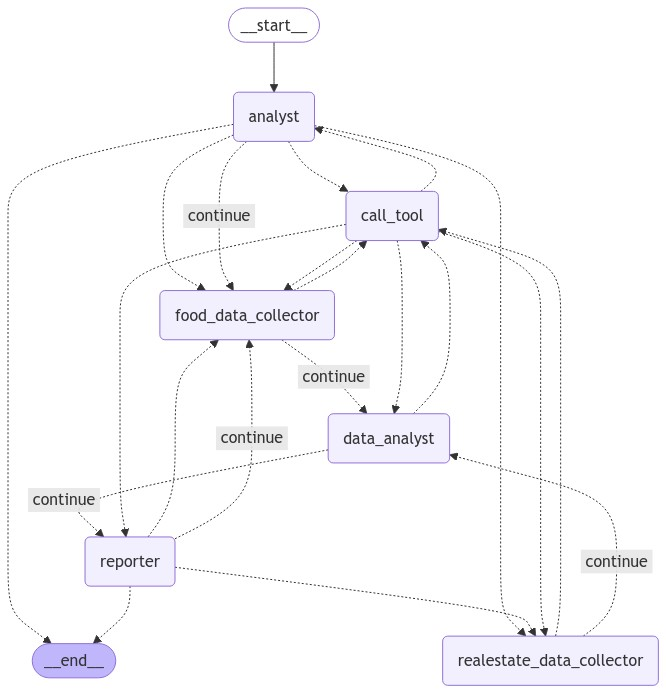

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
result = submitUserMessage("วิเคราะห์ธุรกิจโรงแรมแถวซอยมิตรภาพ 8", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst

I will analyze the hotel business near Soi Mittraphap 8. 

Location: Soi Mittraphap 8  
Keyword: Hotel  
Business Type: Real Estate  

I will pass this information to the real estate data collector for further analysis.
================================== Ai Message ==================================
Name: realestate_data_collector
Tool Calls:
  get_geometric_data (call_SCyoJyRZpQKcYkAVIjH1h3sL)
 Call ID: call_SCyoJyRZpQKcYkAVIjH1h3sL
  Args:
    input_dict: {'keyword': 'hotel', 'location_name': 'Soi Mittraphap 8'}
================================= Tool Message =================================
Name: get_geometric_data


    location: มิตรภาพ ซอย 8

    **nearby competitors**
    number of hotel: 10

        - **โรงแรมสยามวันไนน์ Siam One Nine Hotel**
        	address: 24WM+7MX 1508 Cho Ho, Mueang Nakhon Ratchasima District
        	rating: 4.6
        
        - **MAA KORAT**
        	addres

In [4]:
result = submitUserMessage("Analyze the feasibility of opening a restaurant near Siam Paragon", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst

I will analyze the feasibility of opening a restaurant near Siam Paragon. 

- **Location**: Near Siam Paragon
- **Keyword**: Restaurant
- **Business Type**: Food

I will now pass this information to the Data Collector for further analysis.
================================== Ai Message ==================================
Name: food_data_collector
Tool Calls:
  get_geometric_data (call_E4RsUGqu74KxHzZthvVWUaTs)
 Call ID: call_E4RsUGqu74KxHzZthvVWUaTs
  Args:
    keyword: restaurant
    location_name: Siam Paragon
  find_place_from_text (call_210tK610HF6lm1vU8eP8Mkc8)
 Call ID: call_210tK610HF6lm1vU8eP8Mkc8
  Args:
    location: Siam Paragon
================================= Tool Message =================================
Name: get_geometric_data

Error: ValidationError(model='get_geometric_dataSchema', errors=[{'loc': ('input_dict',), 'msg': 'field required', 'type': 'value_error.missing'}])
 Pl

In [5]:
result = submitUserMessage("วิเคราะห์ร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว วิเคราะห์ความเป็นไปได้ถ้าต้องการขายข้าวในราคา 300", keep_chat_history=True, return_reference=True, verbose=True)


================================== Ai Message ==================================
Name: analyst

I will analyze the feasibility of opening a Thai restaurant near Lumpini Center, Lat Phrao, and the possibility of selling rice at a price of 300 baht. 

First, I will gather the necessary information about the location and the type of business. 

- **Location**: Lumpini Center, Lat Phrao
- **Keyword**: Thai restaurant
- **Business Type**: Food

I will now pass this information to the food data collector for further analysis.
================================== Ai Message ==================================
Name: food_data_collector
Tool Calls:
  get_geometric_data (call_DlmyVXZ6GRvKck5kShot2Oeq)
 Call ID: call_DlmyVXZ6GRvKck5kShot2Oeq
  Args:
    input_dict: {'keyword': 'Thai restaurant', 'location_name': 'Lumpini Center, Lat Phrao'}
================================= Tool Message =================================
Name: get_geometric_data


    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว 111

    **n

In [6]:
result = submitUserMessage("รายงานการวิเคราะห์อสังหาริมทรัพย์ในคลองพระอุดม ปากเกร็ด นนทบุรี", keep_chat_history=True, return_reference=True, verbose=True)


================================== Ai Message ==================================
Name: analyst

I will identify the location and business type from your request. 

- **Location**: คลองพระอุดม, ปากเกร็ด, นนทบุรี
- **Keyword**: อสังหาริมทรัพย์ (real estate)

Now, I will pass this information to the Real Estate Data Collector for further analysis.
================================== Ai Message ==================================
Name: food_data_collector
Tool Calls:
  find_place_from_text (call_vFLFOYLLZEZZGSizZZi1EjhC)
 Call ID: call_vFLFOYLLZEZZGSizZZi1EjhC
  Args:
    location: คลองพระอุดม ปากเกร็ด นนทบุรี
================================= Tool Message =================================
Name: find_place_from_text


    address: คลองพระอุดม ประเทศไทย

    location_name: คลองพระอุดม

    
================================== Ai Message ==================================
Name: food_data_collector
Tool Calls:
  get_geometric_data (call_F85P5ENdjMcWKqs0l41QwtC5)
 Call ID: call_F85P5ENdjMcWKqs0l4

KeyboardInterrupt: 